In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
%matplotlib inline
import sys
sys.path.insert(0,'/Users/djl358/Documents/add_python_packages/pystc/')
import pystc as pystc
from pystc.plots import plot_lift_chart
from pystc.plots import quantile_summary
from pystc.metrics import somers_d


/Users/djl358/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import sklearn.metrics as metrics
def get_scores(y_true, y_pred, y_pred_prob, str_model_nm):
    print("{1} accuracy is {0:0.3f}".format(metrics.accuracy_score(y_true, y_pred), str_model_nm))
    print("{1} precision is {0:0.3f}".format(metrics.precision_score(y_true, y_pred), str_model_nm))
    print("{1} recall is {0:0.3f}".format(metrics.recall_score(y_true, y_pred), str_model_nm))
    print("{1} f1 is {0:0.3f}".format(metrics.f1_score(y_true, y_pred), str_model_nm))
    print("{1} ROC AUC is {0:0.2f}".format(metrics.roc_auc_score(y_true, y_pred_prob), str_model_nm))
def print_roc(y_true, y_pred, y_pred_prob,  md_nm):
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y_true, y_pred_prob)
    roc_auc = metrics.auc(fpr_rf, tpr_rf)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='{1} auc = {0:0.2f}, somersd = {2:0.2f}'.format(roc_auc, md_nm, 2*roc_auc-1))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

def plot_fet_imp(df, model, n):
    fet_nm = df.columns
    fet_id = np.argsort(model.feature_importances_)[::-1]
    fet_imp = model.feature_importances_[fet_id]
    plt.bar(range(n), fet_imp[:n])
    plt.xticks(range(n), fet_nm[fet_id][:n], rotation='vertical')
    plt.show()
    print('Total importance for top {1} features: {0:0.3f}'.format(fet_imp[:n].sum(), n))
def calc_pred_predp(X_Train, X_Test, model):
    y_pred_Train_p = model.predict_proba(X_Train)[:, 1]
    y_pred_Test_p = model.predict_proba(X_Test)[:, 1]
    y_pred_Train = model.predict(X_Train)
    y_pred_Test = model.predict(X_Test)
    return y_pred_Train_p, y_pred_Test_p, y_pred_Train, y_pred_Test

def somers_plots(preds, bins=40):
    figsize(16,8)
    df = pd.DataFrame()
    for model, pred in preds.iteritems():
        mname = str(model)[:str(model).find("(")]
        #p = np.array(pd.DataFrame(pred).sort((0,1)))
        p = pred[pred.argsort(0)[:,0]]
        pct = []
        for i in xrange(bins):
            start = int(float(i)/bins*len(p))
            end = int(float(i+1)/bins*len(p))
            pct.append((i, np.mean(p[start:end,1])))
        pct = np.array(pct)
        for i in pct[:,1]:
            print (i)
        som = ' (%.3f)' % somersd(p[:,0], p[:,1])
        df = pd.concat([df, pd.DataFrame([pct, mname+som, som]).T])
         
    for k, v in df.sort(2, ascending=False).iterrows():
        pct = v.get_values()[0]
        plot(pct[:,0], pct[:,1], label=v[1])
    
    ylim(0,0.8)
    legend(loc='lower right')
    show()
def plot_hist_boxplot(var_name, by_var_name, df):
    fig, ax1 = plt.subplots()
    length = len(df[by_var_name].value_counts().index)
    plt.xticks(range(length), df.groupby([by_var_name])[var_name].mean().index, rotation='vertical')
    ax1.plot(range(length), df.groupby([by_var_name])[var_name].mean(), color = 'g', marker = 'o')
    print(df.groupby([by_var_name])[var_name].mean())
    print(df.groupby([by_var_name])[var_name].count())
    ax2 = ax1.twinx()
    ax2.bar(range(length), df.groupby([by_var_name])[var_name].count(), alpha=0.4)
    plt.title(by_var_name)
    plt.show()

## 1. Data exploration

In [3]:
os.chdir('/Users/djl358/Documents/new_search/')
loan_data = pd.read_csv('Loan Granting Binary Classification.csv')
loan_data.columns = loan_data.columns.str.lower()

In [4]:
print(loan_data.shape)
loan_data.head()

(111105, 19)


,loan id,customer id,loan status,current loan amount,term,credit score,years in current job,home ownership,annual income,purpose,monthly debt,years of credit history,months since last delinquent,number of open accounts,number of credit problems,current credit balance,maximum open credit,bankruptcies,tax liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,"1,244.02",16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [5]:
print('there are {0} records'.format(loan_data.shape[0]))
print('there are {0} unique loan'.format(loan_data['loan id'].nunique()))
print('there are {0} unique customer'.format(loan_data['customer id'].nunique()))
print('there are {0} fully duplicated record'.format(loan_data[loan_data.duplicated()].shape[0]))

there are 111105 records
there are 88908 unique loan
there are 88908 unique customer
there are 12526 fully duplicated record


## 1.1. remove duplicate data

In [6]:
# remove the abslute duplicates
loan_data.drop_duplicates(inplace=True)
loan_data.sort_values(['loan id'], inplace=True)
print(loan_data.shape)
# there are some duplicated loan id with different info
dup_data = loan_data.loc[loan_data['loan id'].isin(loan_data[loan_data['loan id'].duplicated()]['loan id'])]
dup_data.head(10)

(98579, 19)


,loan id,customer id,loan status,current loan amount,term,credit score,years in current job,home ownership,annual income,purpose,monthly debt,years of credit history,months since last delinquent,number of open accounts,number of credit problems,current credit balance,maximum open credit,bankruptcies,tax liens
97429,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Fully Paid,13719,Short Term,724.0,1 year,Own Home,34297.0,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0
32051,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Fully Paid,13719,Short Term,NaN,1 year,Own Home,NaN,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0
32217,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Fully Paid,1433,Short Term,NaN,10+ years,Home Mortgage,NaN,Home Improvements,"2,627.76",15.1,5.0,22,0,27706,49563,0.0,0.0
97876,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Fully Paid,1433,Short Term,716.0,10+ years,Home Mortgage,108735.0,Home Improvements,"2,627.76",15.1,5.0,22,0,27706,49563,0.0,0.0
96169,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Fully Paid,34185,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,"1,881.29",25.9,NaN,20,0,37507,50961,0.0,0.0
12700,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Fully Paid,99999999,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,"1,881.29",25.9,NaN,20,0,37507,50961,0.0,0.0
11542,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Fully Paid,99999999,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,"2,204.13",18.0,NaN,22,0,21135,34366,0.0,0.0
108034,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Fully Paid,21075,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,"2,204.13",18.0,NaN,22,0,21135,34366,0.0,0.0
12981,001312a5-ed3c-4930-9525-4d09c55ba7f4,982e93b2-ded4-443f-a64f-1df15eb9b7cd,Fully Paid,99999999,Long Term,705.0,6 years,Home Mortgage,108955.0,major_purchase,883.45,23.6,54.0,10,1,8906,21511,1.0,0.0
90752,001312a5-ed3c-4930-9525-4d09c55ba7f4,982e93b2-ded4-443f-a64f-1df15eb9b7cd,Fully Paid,34668,Long Term,705.0,6 years,Home Mortgage,108955.0,major_purchase,883.45,23.6,54.0,10,1,8906,21511,1.0,0.0


In [7]:
# dedup the data based on loan id
# change default to NA for dedup, select the max loan_amt per application. 
# create df for other variables for de-dup process
loan_data['target'] = loan_data['loan status'].apply(lambda x: 0.0 if x=='Fully Paid' else 1.0)
loan_data['curr_loan_amt_tmp'] = loan_data['current loan amount'].apply(lambda x: np.nan if x==99999999 else x)
curr_loan_amt = loan_data.groupby(['loan id'])['curr_loan_amt_tmp'].max().to_frame()
credit_score = loan_data.groupby(['loan id'])['credit score'].min().to_frame()
annual_income = loan_data.groupby(['loan id'])['annual income'].min().to_frame()
target = loan_data.groupby(['loan id'])['target'].max().to_frame()

In [8]:
# join the correct variable to data
join = curr_loan_amt.merge(credit_score, left_index=True, right_index=True)
join = join.merge(annual_income, left_index=True, right_index=True)
join = join.merge(target, left_index=True, right_index=True)
join.rename(columns={'target':'targetdp', 'curr_loan_amt_tmp':'curr_loan_amt', 'credit score': 'credit_score',
             'annual income':'annual_income'}, inplace=True)

In [9]:
data_dp = loan_data.merge(join, left_on='loan id', right_index=True, how='left')

In [10]:
# de-dup the data and remove extra incorrect variables
data_dp.drop_duplicates(['loan id'], keep='last', inplace=True)
data_dp.drop(['loan status','current loan amount','curr_loan_amt_tmp',
              'credit score','annual income', 'target'], axis=1, inplace=True)

In [11]:
print(data_dp.shape)
print(data_dp['loan id'].nunique())
print(data_dp['customer id'].nunique())

(88908, 19)
88908
88908


## 1.2. variable formatting


In [12]:
# correct the data format
data_dp['monthly debt'] = pd.to_numeric(data_dp['monthly debt'].apply(lambda x: x.replace(",","")))

In [13]:
col_ls_str = [item for item in data_dp.columns if data_dp[item].dtype=='O']
col_ls_str.remove('loan id')
col_ls_str.remove('customer id')
col_ls_num = [item for item in data_dp.columns if data_dp[item].dtype in ('int64', 'float64')]
col_ls_num.remove('targetdp')
print(col_ls_str) 
print(col_ls_num)

['term', 'years in current job', 'home ownership', 'purpose']
['monthly debt', 'years of credit history', 'months since last delinquent', 'number of open accounts', 'number of credit problems', 'current credit balance', 'maximum open credit', 'bankruptcies', 'tax liens', 'curr_loan_amt', 'credit_score', 'annual_income']


## 1.3. exploration and univariate chart 


###  Print the descriptive statistics of numerical columns


In [14]:
def num_missing(x):
    return len(x.index)-x.count()
missing_df = pd.DataFrame(data_dp[col_ls_num].apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
tmp_df_sum = data_dp[col_ls_num].describe().T
summary_df_num = tmp_df_sum.join(missing_df)
summary_df_num

,count,mean,std,min,25%,50%,75%,max,missing
monthly debt,88908.0,963.096546,637.521484,0.0,532.22,843.925,1250.5225,22939.12,0
years of credit history,88908.0,18.315301,7.049233,3.6,13.50,17.000,21.8000,70.50,0
months since last delinquent,40402.0,35.080466,22.009079,0.0,16.00,32.000,51.0000,176.00,48506
number of open accounts,88908.0,11.110463,4.978438,0.0,8.00,10.000,14.0000,76.00,0
number of credit problems,88908.0,0.160480,0.473751,0.0,0.00,0.000,0.0000,15.00,0
current credit balance,88908.0,15436.279986,19658.810650,0.0,5949.00,11039.000,19301.0000,1730472.00,0
maximum open credit,88908.0,35965.310175,404180.505891,0.0,12775.00,21781.000,36367.0000,69988086.00,0
bankruptcies,88716.0,0.112674,0.343303,0.0,0.00,0.000,0.0000,7.00,192
tax liens,88900.0,0.028223,0.257536,0.0,0.00,0.000,0.0000,15.00,8
curr_loan_amt,80592.0,13984.381837,8291.837569,491.0,7810.75,12058.000,19493.2500,35875.00,8316


term
Long Term     0.421512
Short Term    0.237666
Name: targetdp, dtype: float64
term
Long Term     21978
Short Term    66930
Name: targetdp, dtype: int64


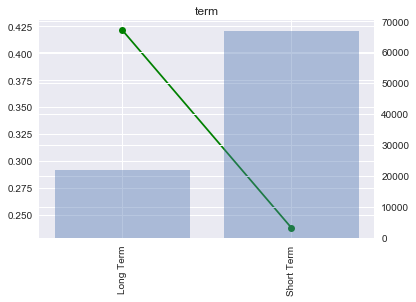

years in current job
1 year       0.289159
10+ years    0.271553
2 years      0.271073
3 years      0.270687
4 years      0.282791
5 years      0.280408
6 years      0.287537
7 years      0.290310
8 years      0.287457
9 years      0.298671
< 1 year     0.287473
n/a          0.368876
Name: targetdp, dtype: float64
years in current job
1 year        5765
10+ years    27409
2 years       8186
3 years       7263
4 years       5474
5 years       6084
6 years       5095
7 years       4943
8 years       4098
9 years       3462
< 1 year      7312
n/a           3817
Name: targetdp, dtype: int64


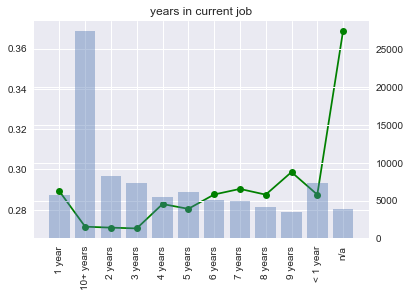

home ownership
HaveMortgage     0.200000
Home Mortgage    0.254980
Own Home         0.289412
Rent             0.314685
Name: targetdp, dtype: float64
home ownership
HaveMortgage       170
Home Mortgage    43270
Own Home          8075
Rent             37393
Name: targetdp, dtype: int64


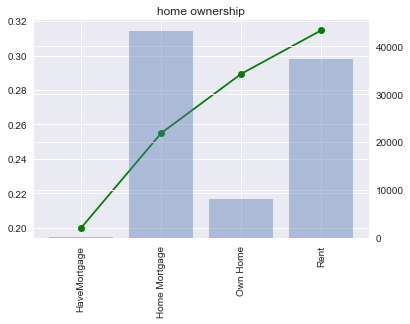

purpose
Business Loan           0.401355
Buy House               0.284436
Buy a Car               0.195652
Debt Consolidation      0.282717
Educational Expenses    0.228261
Home Improvements       0.248944
Medical Bills           0.325654
Other                   0.234035
Take a Trip             0.270925
major_purchase          0.287791
moving                  0.395161
other                   0.319707
renewable_energy        0.444444
small_business          0.528226
vacation                0.365854
wedding                 0.262626
Name: targetdp, dtype: float64
purpose
Business Loan            1328
Buy House                 559
Buy a Car                1196
Debt Consolidation      70445
Educational Expenses       92
Home Improvements        5206
Medical Bills             955
Other                    2850
Take a Trip               454
major_purchase            344
moving                    124
other                    4917
renewable_energy            9
small_business            248
vacat

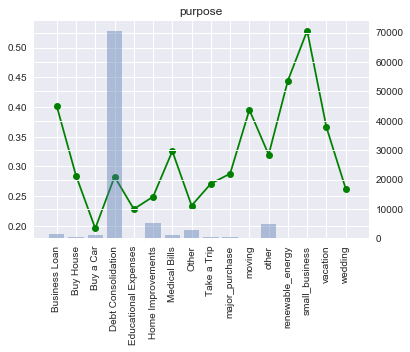

In [15]:
for col in col_ls_str:
    plot_hist_boxplot('targetdp', col, data_dp)

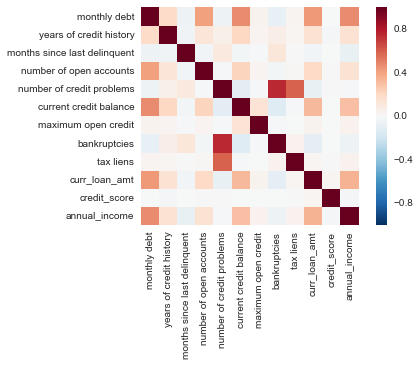

In [16]:
sns.heatmap(data_dp[col_ls_num].corr(), square=True)

In [17]:
#pd.plotting.scatter_matrix(data_dp[col_ls_num],figsize=(16, 16))


### EXPLORE the target variable

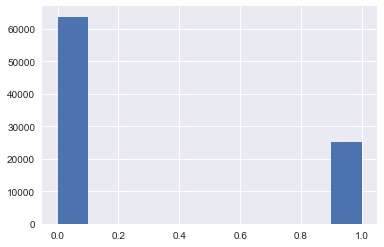

In [18]:
data_dp['targetdp'].hist()

### numerical univariate chart

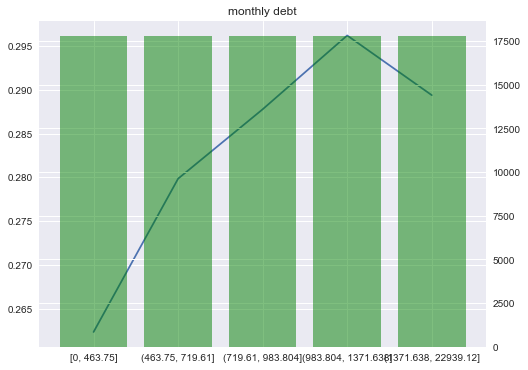

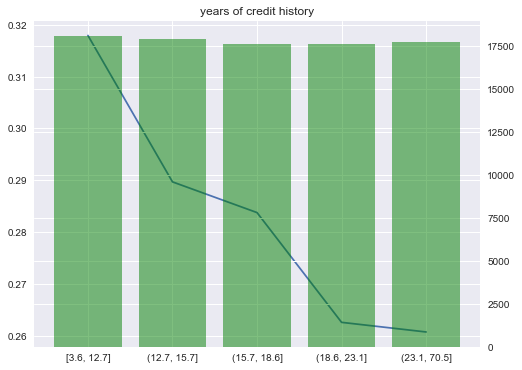

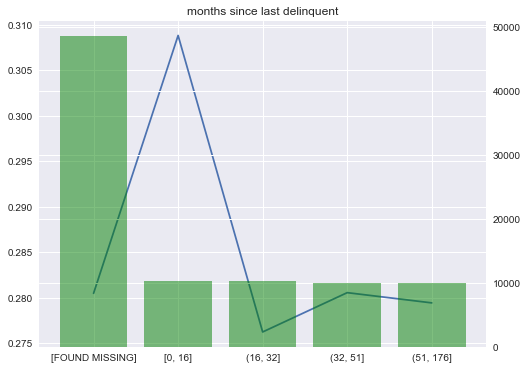

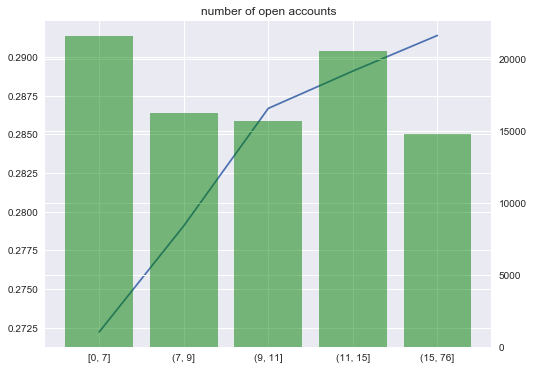

WARNING|2017-06-29 21:28:44,612|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 4 in order to create partions.
WARNING|2017-06-29 21:28:44,614|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 4 in order to create partions.
WARNING|2017-06-29 21:28:44,616|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 4 in order to create partions.
WARNING|2017-06-29 21:28:44,618|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 4 in order to create partions.
WARNING|2017-06-29 21:28:44,628|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 4 in order to create partions.


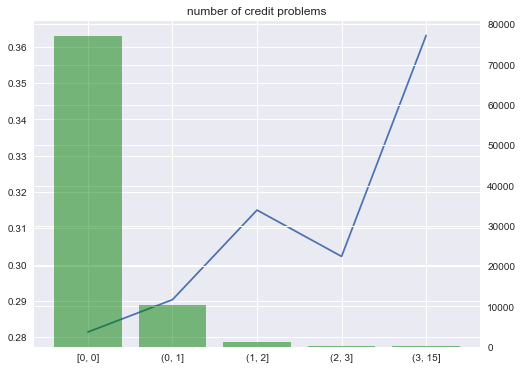

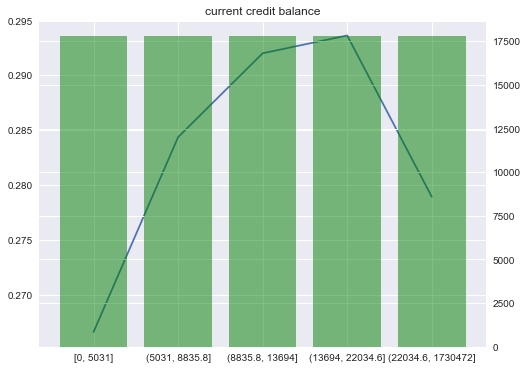

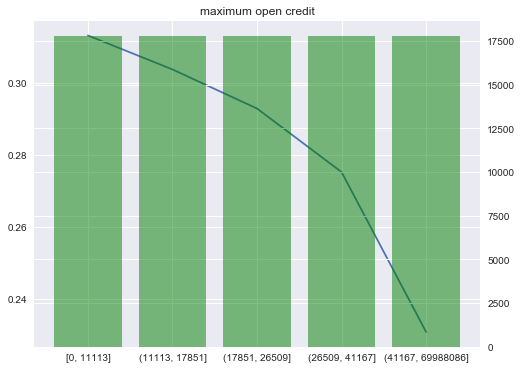

WARNING|2017-06-29 21:28:45,902|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.
WARNING|2017-06-29 21:28:45,903|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.
WARNING|2017-06-29 21:28:45,906|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.
WARNING|2017-06-29 21:28:45,916|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.


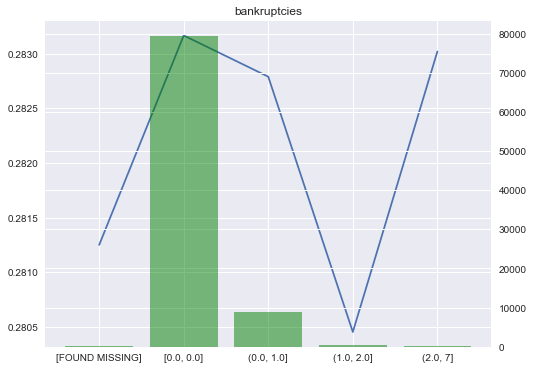

WARNING|2017-06-29 21:28:46,492|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.
WARNING|2017-06-29 21:28:46,493|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.
WARNING|2017-06-29 21:28:46,495|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.
WARNING|2017-06-29 21:28:46,505|pystc.utils._qcut|_qcut.py|_recursive_qcut|226: Number of quantiles was decremented by 3 in order to create partions.


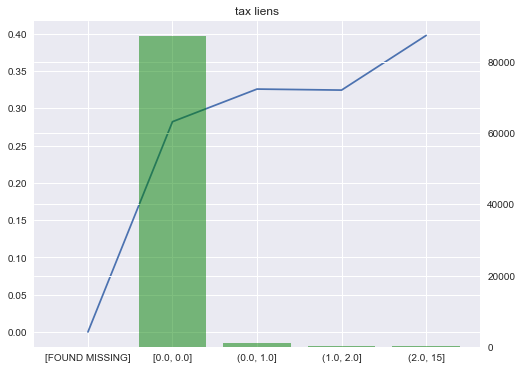

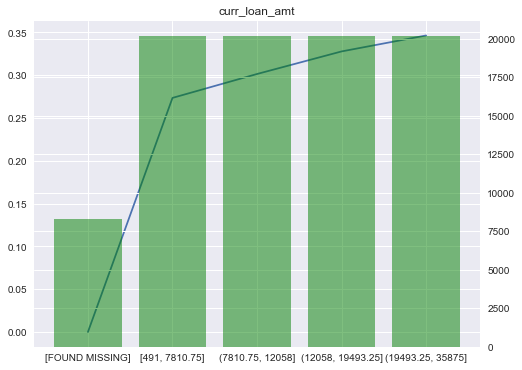

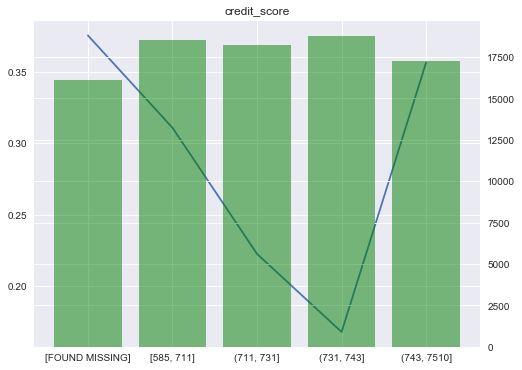

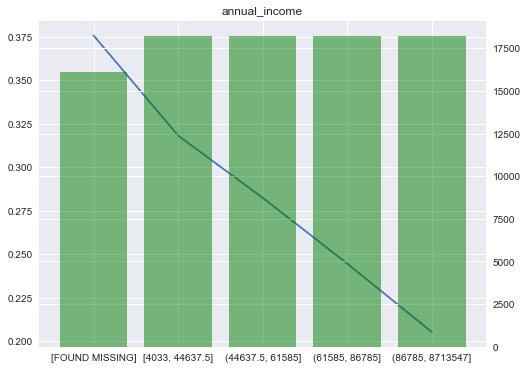

In [19]:

def plot_univariate(var_name, by_var_name, df):
    plt.figure(figsize=(8,6))
    output_df = quantile_summary(data_dp[by_var_name], data_dp[var_name], quantiles=5)
    ax1 = plt.gca()
    ax1.plot(range(5),output_df['y_avg'])
    ax2 = ax1.twinx()
    ax2.bar(range(5), output_df['count'], color='g', alpha=0.5)
    plt.xticks(range(5), output_df.index, rotation='vertical')
    plt.title(by_var_name)
    plt.show()

for var in col_ls_num:
    plot_univariate('targetdp', var, data_dp)


## 2 data cleaning 

In [20]:
data_dummies = pd.get_dummies(data_dp[col_ls_str])

In [21]:
data_dummies.columns

Index(['term_Long Term', 'term_Short Term', 'years in current job_1 year',
       'years in current job_10+ years', 'years in current job_2 years',
       'years in current job_3 years', 'years in current job_4 years',
       'years in current job_5 years', 'years in current job_6 years',
       'years in current job_7 years', 'years in current job_8 years',
       'years in current job_9 years', 'years in current job_< 1 year',
       'years in current job_n/a', 'home ownership_HaveMortgage',
       'home ownership_Home Mortgage', 'home ownership_Own Home',
       'home ownership_Rent', 'purpose_Business Loan', 'purpose_Buy House',
       'purpose_Buy a Car', 'purpose_Debt Consolidation',
       'purpose_Educational Expenses', 'purpose_Home Improvements',
       'purpose_Medical Bills', 'purpose_Other', 'purpose_Take a Trip',
       'purpose_major_purchase', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purp

In [22]:
data_dp = data_dp.merge(data_dummies, how='inner', left_index=True, right_index=True)

In [23]:
data_dp_X = data_dp[col_ls_num+data_dummies.columns.tolist()]

## 3. split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_dp_X, data_dp['targetdp'], test_size=0.3, random_state=0)
X_train.shape

(62235, 46)

In [25]:
X_train.head()

,monthly debt,years of credit history,months since last delinquent,number of open accounts,number of credit problems,current credit balance,maximum open credit,bankruptcies,tax liens,curr_loan_amt,...,purpose_Medical Bills,purpose_Other,purpose_Take a Trip,purpose_major_purchase,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
43459,1390.22,29.0,27.0,8,0,27860,50838,0.0,0.0,20482.0,...,0,0,0,0,0,0,0,0,0,0
55470,956.57,22.7,NaN,12,0,10762,18848,0.0,0.0,10742.0,...,0,0,0,0,0,0,0,0,0,0
22323,966.99,18.0,26.0,14,0,28309,29550,0.0,0.0,17070.0,...,0,0,0,0,0,0,0,0,0,0
73582,592.63,22.4,9.0,8,0,20512,36693,0.0,0.0,25470.0,...,0,0,0,0,0,0,0,0,0,0
23833,504.40,19.0,30.0,11,1,666,9121,1.0,0.0,10088.0,...,0,0,0,0,0,0,0,0,0,0


## 4. missing value 

In [26]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_train)
X_train_imp = imp.transform(X_train)

In [27]:
imp_test = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_test.fit(X_test)
X_test_imp = imp_test.transform(X_test)

## 5. train model 

### 5.1 with random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=3, n_estimators=100)
rf.fit(X_train_imp, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
from sklearn.grid_search import GridSearchCV
tuned_parameters = {'max_depth': [4,6], 'n_estimators': [100,300],'min_samples_split':[2, 10]}
scores = 'roc_auc'
clf = GridSearchCV(rf, tuned_parameters, cv=5, scoring=scores)
clf.fit(X_train_imp, y_train)


/Users/djl358/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300], 'max_depth': [4, 6], 'min_samples_split': [2, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [30]:
clf.grid_scores_

[mean: 0.74321, std: 0.00266, params: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2},
 mean: 0.74235, std: 0.00132, params: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 2},
 mean: 0.74287, std: 0.00344, params: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 10},
 mean: 0.74224, std: 0.00303, params: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 10},
 mean: 0.75209, std: 0.00207, params: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2},
 mean: 0.75191, std: 0.00258, params: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 2},
 mean: 0.75113, std: 0.00323, params: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 10},
 mean: 0.75175, std: 0.00180, params: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 10}]

In [31]:
rf_best = RandomForestClassifier(max_depth=6, n_estimators=300, min_samples_split=10)
rf_best.fit(X_train_imp, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [32]:
y_pred_Train_p = rf.predict_proba(X_train_imp)[:, 1]
y_pred_Train = rf.predict(X_train_imp)
y_pred_test_p = rf.predict_proba(X_test_imp)[:, 1]
y_pred_test = rf.predict(X_test_imp)

In [33]:
y_pred_Train_best_p = rf_best.predict_proba(X_train_imp)[:, 1]
y_pred_Train_best = rf_best.predict(X_train_imp)
y_pred_test_best_p = rf_best.predict_proba(X_test_imp)[:, 1]
y_pred_test_best = rf_best.predict(X_test_imp)

train accuracy is 0.746
train precision is 1.000
train recall is 0.100
train f1 is 0.182
train ROC AUC is 0.74
test accuracy is 0.744
test precision is 1.000
test recall is 0.102
test f1 is 0.185
test ROC AUC is 0.72


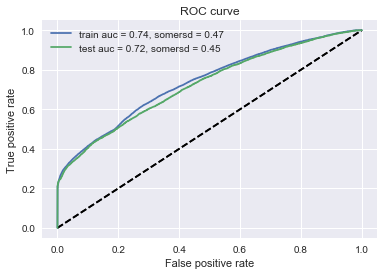

In [34]:
get_scores(y_train, y_pred_Train, y_pred_Train_p, 'train')
print_roc(y_train, y_pred_Train, y_pred_Train_p,  'train')
get_scores(y_test, y_pred_test, y_pred_test_p, 'test')
print_roc(y_test, y_pred_test, y_pred_test_p,  'test')


train_best accuracy is 0.789
train_best precision is 0.929
train_best recall is 0.276
train_best f1 is 0.425
train_best ROC AUC is 0.76
test_best accuracy is 0.782
test_best precision is 0.971
test_best recall is 0.242
test_best f1 is 0.387
test_best ROC AUC is 0.74


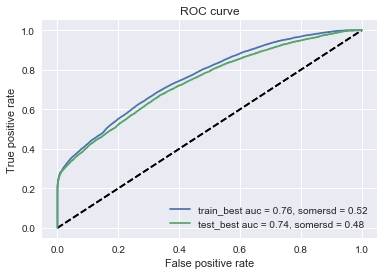

In [35]:
get_scores(y_train, y_pred_Train_best, y_pred_Train_best_p, 'train_best')
print_roc(y_train, y_pred_Train_best, y_pred_Train_best_p,  'train_best')
get_scores(y_test, y_pred_test_best, y_pred_test_best_p, 'test_best')
print_roc(y_test, y_pred_test_best, y_pred_test_best_p,  'test_best')

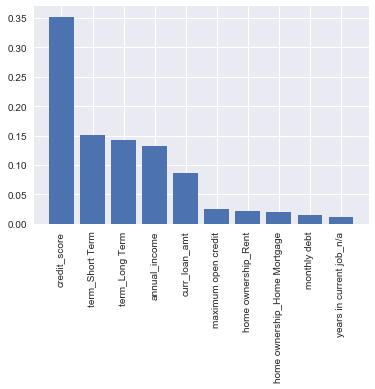

Total importance for top 10 features: 0.958


In [36]:
sum(rf.feature_importances_)
plot_fet_imp(X_train, rf, 10)

### 5.2 logistic regression

In [37]:
from sklearn.linear_model import LogisticRegressionCV
lgr = LogisticRegressionCV(cv=5, penalty='l1', Cs=[0.01, 1, 10], solver='liblinear', scoring='roc_auc')
lgr.fit(X_train_imp, y_train)

LogisticRegressionCV(Cs=[0.01, 1, 10], class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [38]:
from sklearn.linear_model import LogisticRegression
lgrm = LogisticRegression(penalty='l1', C=0.01)
lgrm.fit(X_train_imp, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
lgrm.coef_

array([[  2.40333918e-04,  -1.48916057e-02,  -4.64722920e-03,
          2.51884517e-03,   5.66150425e-02,   2.53631956e-06,
         -2.69414677e-06,   0.00000000e+00,   0.00000000e+00,
          8.64616247e-06,   1.81329778e-03,  -7.86687295e-06,
          0.00000000e+00,  -9.56641561e-01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.65010557e-01,   0.00000000e+00,
         -2.92225860e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -1.40627625e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]])

In [40]:
y_pred_Train_p = lgrm.predict_proba(X_train_imp)[:, 1]
y_pred_Train = lgrm.predict(X_train_imp)
y_pred_test_p = lgrm.predict_proba(X_test_imp)[:, 1]
y_pred_test = lgrm.predict(X_test_imp)

train accuracy is 0.787
train precision is 0.917
train recall is 0.272
train f1 is 0.419
train ROC AUC is 0.73
test accuracy is 0.785
test precision is 0.916
test recall is 0.270
test f1 is 0.417
test ROC AUC is 0.73


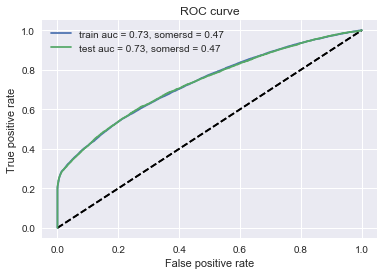

In [41]:
get_scores(y_train, y_pred_Train, y_pred_Train_p, 'train')
print_roc(y_train, y_pred_Train, y_pred_Train_p,  'train')
get_scores(y_test, y_pred_test, y_pred_test_p, 'test')
print_roc(y_test, y_pred_test, y_pred_test_p,  'test')
#from sklearn.metrics import confusion_matrixx
#confmat = confusion_matrix(y_train, y_pred_Train)
#print(confmat)


In [42]:
from statsmodels.discrete.discrete_model import Logit
smlg = Logit(y_train, X_train_imp)
smrl = smlg.fit()
from statsmodels.stats.outliers_influence import variance_inflation_factor


Optimization terminated successfully.
         Current function value: 0.485288
         Iterations 9
